In [1]:
using RHEOS
using PyPlot

┌ Info: Precompiling RHEOS [728860ae-c896-11e8-0b91-0f38ecad5046]
└ @ Base loading.jl:1278


LoadError: InterruptException:

# Define new Kelvin-Voigt and the deriv functions

In [2]:
rKelvinVoigt =  RheoModelClass(
        # Model name
        name="KV",
        # Model parameters,
        p = [:η, :k],
        # Relaxation modulus
        G = quote
              k*t+η
            end,
        # Creep modulus
        J = quote
                (t/k) - (η/(k^2)) + (η*exp(-k*t/η)/(k^2))
              # (1 - exp(-k*t/η))/k
            end,
        # Storage modulus
        Gp = quote
                k
             end,
        # Loss modulus
        Gpp = quote
                η*ω
              end,
        # Network
        info= "
                        ___
                _________| |________
               |        _|_| η      |
           ____|                    |____
               |                    |
               |____╱╲  ╱╲  ╱╲  ____|
                      ╲╱  ╲╱  ╲╱
                                k
                "
                )

LoadError: UndefVarError: RheoModelClass not defined

In [3]:
# For some reason, wasn't able to use the derivBD and derivCD functions - maybe because they are defined in base.jl??
"""
    derivBD(y, x)
Given two arrays of data, x and y, calculate dy/dx using 1st order
backward difference. Assumes y==0 at a previous point, i.e.
y is 'at rest'. Captures instantaneous loading where derivCD will smooth.
"""
function myderivBD(y::Vector{RheoFloat}, x::Vector{RheoFloat})

    # get length
    N = length(x)

    # assert y and x arrays are same length
    @assert length(y)==N "X and Y Array lengths must match."

    # initialise zero array of length y
    ydot = similar(y)

    # assume 'imaginary' previous point is 0.0, and Δx is the same as the next one ahead
    # this is a physical assumption that material is at rest before first data point.
    # Could be problematic in some cases if sudden jump as we are actually missing
    # important information about how quickly that jump happened.
    @inbounds ydot[1] = y[1]/(x[2] - x[1])

    # backwards difference method for rest of points
    @inbounds for i in 2:N
        ydot[i] = (y[i] - y[i-1])/(x[i] - x[i-1])
    end

    return ydot

end

function myderivCD(y::Vector{RheoFloat}, x::Vector{RheoFloat})

    # get length
    N = length(x)

    # assert y and x arrays are same length
    @assert length(y)==N "X and Y Array lengths must match."

    # initialise zero array of length y
    ydot = similar(y)

    # assume 'imaginary' previous point is 0.0, and Δx is the same as the next one ahead
    # this is a physical assumption that material is at rest before first data point.
    # Could be problematic in some cases if sudden jump as we are actually missing
    # important information about how quickly that jump happened.
    @inbounds ydot[1] = y[1]/(x[2] - x[1])

    # central difference with uneven spacing for general case of constant or variable sample rate
    @inbounds for i in 2:(N-1)
        Δx₁ = x[i] - x[i-1]
        Δx₂ = x[i+1] - x[i]
        ydot[i] = (y[i+1]*Δx₁^2 + (Δx₂^2 - Δx₁^2)*y[i] - y[i-1]*Δx₂^2)/(Δx₁*Δx₂*(Δx₁ + Δx₂))
    end

    # 1st order backwards difference for last element
    ydot[N] = (y[N] - y[N-1])/(x[N] - x[N-1])

    return ydot

end


LoadError: UndefVarError: RheoFloat not defined

# Create RheoTimeData and get response to some input

In [4]:
datat = timeline(t_start=0, t_end=20.0, step = 0.02)
RheoTimeDataType(datat)

LoadError: UndefVarError: timeline not defined

In [5]:
data = strainfunction(datat,hstep(offset=5.0,amp=5));
# data = strainfunction(datat, t->sin(t))
# data = strainfunction(datat,ramp(offset=2.0,gradient=0.8));
# data = strainfunction(datat,ramp(offset=2.0,gradient=0.8)) - strainfunction(datat,ramp(offset=5.0,gradient=0.8));

LoadError: UndefVarError: hstep not defined

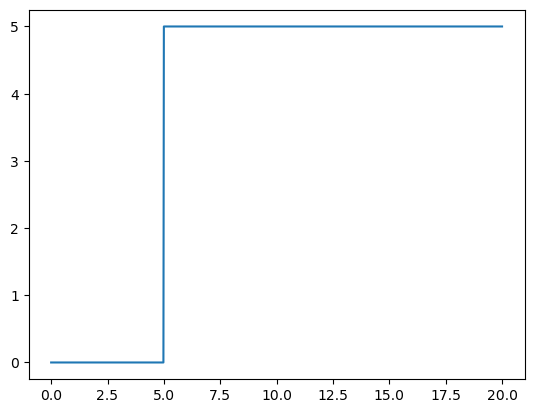

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000453D0580>

In [28]:
plot(data.t, data.ϵ)

Now to get the target response

In [29]:
rkv_model = RheoModel(rKelvinVoigt, k = 4, η = 5)

my_ϵ = myderivCD(data.ϵ, data.t); # differentiate the σ
data = RheoTimeData([], my_ϵ, data.t, data.log)
d_kv = modelpredict(data, rkv_model)

t =	0.0	0.02	0.04	0.06	0.08	0.1	0.12	0.14	0.16	0.18	...
ϵ =	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	...
σ =	3.4093058535030907e-12	1.2034202911077982e-12	1.5152470460013735e-12	3.644908290533792e-12	3.4116156813171172e-12	1.382431946694851e-12	2.9889171913502706e-12	2.2590116021179016e-12	1.5198667016294268e-12	2.476135416636391e-12	...


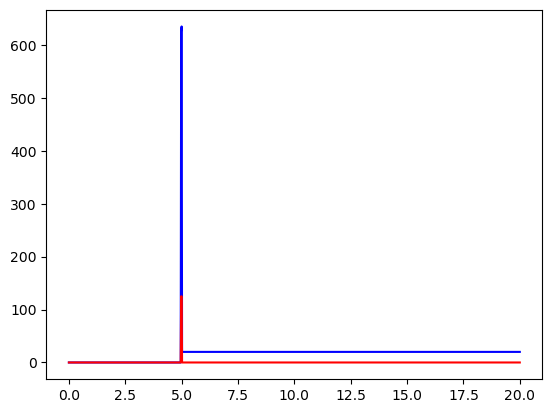

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000004542CBB0>

In [30]:
plot(d_kv.t,d_kv.σ, "b")
plot(d_kv.t, d_kv.ϵ, "r")

# Create a new KV and fit to the data

In [31]:
rkv_model2 = RheoModel(rKelvinVoigt, k = 4, η = 5)


Model: KV

Parameter values: (η = 5.0, k = 4.0) 

                        ___
                _________| |________
               |        _|_| η      |
           ____|                    |____
               |                    |
               |____╱╲  ╱╲  ╱╲  ____|
                      ╲╱  ╲╱  ╲╱
                                k
                

In [32]:
new_data = d_kv
rkv_model3 = modelfit(new_data, rKelvinVoigt, strain_imposed)

Time: 0.029753299 s, Why: XTOL_REACHED, Parameters: [4.99997615814209, 3.9999842643737793], Error: 2.26422812953956e-5

┌ Warning: Initial values for model parameters are set to [0.5, 0.5] by default
└ @ RHEOS C:\Users\sanja\.julia\packages\RHEOS\UUrax\src\processing.jl:250



Model: KV

Parameter values: (η = 4.99997615814209, k = 3.9999842643737793) 

                        ___
                _________| |________
               |        _|_| η      |
           ____|                    |____
               |                    |
               |____╱╲  ╱╲  ╱╲  ____|
                      ╲╱  ╲╱  ╲╱
                                k
                

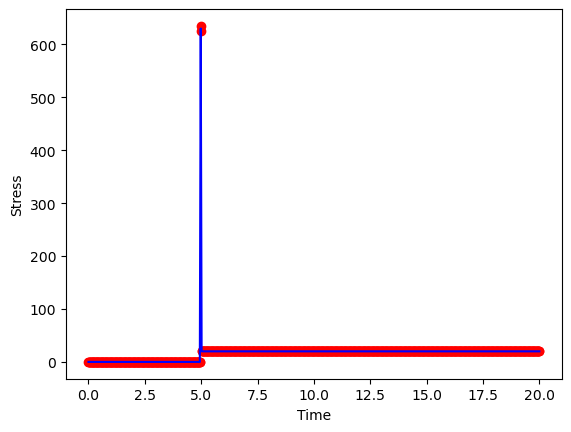

In [33]:
data = d_kv

# my_σ = myderivCD(data.σ, data.t);
# new_data = RheoTimeData(my_σ, data.ϵ, data.t, data.log)

data_ext = extract(data,strain_only); # use the d(stress) for prediction

rkv_predict = modelpredict(data_ext, rkv_model, diff_method = "CD")

# Now we can plot data and model together for comparison
plot(data.t,data.σ, "or");
plot(rkv_predict.t,rkv_predict.σ, "b");


xlabel("Time");
ylabel("Stress");